# How to Train Detectron2 on Custom Objects

This tutorial implements the new [Detectron2 Library](https://ai.facebook.com/blog/-detectron2-a-pytorch-based-modular-object-detection-library-/) by facebook. This notebook shows training on **your own custom objects** for object detection.

It is worth noting that the Detectron2 library goes far beyond object detection, supporting semantic segmentation, keypoint detection, mask, and densepose.


### Accompanying Blog Post

We recommend that you follow along in this notebook while reading the blog post on [how to train Detectron2](https://blog.roboflow.ai/how-to-train-detectron2/), concurrently.

### Steps Covered in this Tutorial

In this tutorial, we will walk through the steps required to train Detectron2 on your custom objects. We use a [public blood cell detection dataset](https://public.roboflow.ai/object-detection/bccd), which is open source and free to use. You can also use this notebook on your own data.

To train our detector we take the following steps:

* Install Detectron2 dependencies
* Download custom Detectron2 object detection data
* Visualize Detectron2 training data
* Write our Detectron2 Training configuration
* Run Detectron2 training
* Evaluate Detectron2 performance
* Run Detectron2 inference on test images



### **About**

[Roboflow](https://roboflow.ai) enables teams to deploy custom computer vision models quickly and accurately. Convert data from to annotation format, assess dataset health, preprocess, augment, and more. It's free for your first 1000 source images.

#### ![Roboflow Workmark](https://i.imgur.com/WHFqYSJ.png)

# Install Detectron2 Dependencies

In [1]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
Requirement already up-to-date: torch==1.5 in /usr/local/lib/python3.6/dist-packages (1.5.0+cu101)
Requirement already up-to-date: torchvision==0.6 in /usr/local/lib/python3.6/dist-packages (0.6.0+cu101)
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-9kg45h9i
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-9kg45h9i
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=266459 sha256=32aa91423f69aa2d8116fca9184ed2b2a656737f0c750270c447d73bae69a5d2
  Stored in directory: /tmp/pip-ephem-wheel-cache-y5ynmn2p/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0
1.5.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free

In [2]:
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html


In [3]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog

# Import and Register Custom Detectron2 Data

In [4]:
!curl -L "https://app.roboflow.com/ds/0JMdq2V5l2?key=MAmmTcuE4Q" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   887  100   887    0     0   1134      0 --:--:-- --:--:-- --:--:--  1135
100 11.1M  100 11.1M    0     0  6541k      0  0:00:01  0:00:01 --:--:-- 11.7M
Archive:  roboflow.zip
replace test/x0361_png.rf.063c665641a679624cef1723dd10ff61.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace test/x0361_png.rf.063c665641a679624cef1723dd10ff61.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: test/x0361_png.rf.063c665641a679624cef1723dd10ff61.jpg  
 extracting: test/x0027_png.rf.0dff551a487cb60e3f3b7c65dd2c2720.jpg  
 extracting: test/x0118_png.rf.1104b399673be7bfab427c9c3726575f.jpg  
 extracting: test/x0039_png.rf.182105e10c77044952aa58ab85c1d993.jpg  
 extracting: test/x0391_png.rf.4849ffa164175ada3dc81887b06b661c.jpg  
 extracting: test/x0197_png.rf.0fdcde8fed1661b129c4ea1c4f920295.jpg  
 ext

In [7]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/train/_annotations.coco.json", "/content/train")
register_coco_instances("my_dataset_val", {}, "/content/valid/_annotations.coco.json", "/content/valid")
register_coco_instances("my_dataset_test", {}, "/content/test/_annotations.coco.json", "/content/test")


WARNING [10/14 21:49:06 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/14 21:49:06 d2.data.datasets.coco]: Loaded 350 images in COCO format from /content/train/_annotations.coco.json


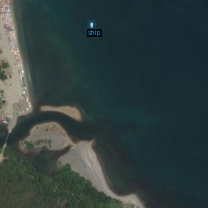

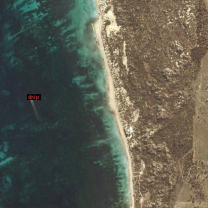

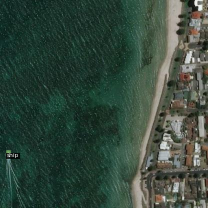

In [9]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

# Train Custom Detectron2 Detector

In [10]:
#We are importing our own Trainer Module here to use the COCO validation evaluation during training. Otherwise no validation eval occurs.

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [11]:
#from .detectron2.tools.train_net import Trainer
#from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
#from detectron2.evaluation.coco_evaluation import COCOEvaluator
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001


cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 1500 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05




cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4 #your number of classes + 1

cfg.TEST.EVAL_PERIOD = 500


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[10/14 21:49:29 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_68b088.pkl: 421MB [00:37, 11.2MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.


[10/14 21:50:12 d2.engine.train_loop]: Starting training from iteration 0
[10/14 21:50:50 d2.utils.events]:  eta: 0:46:22  iter: 19  total_loss: 2.680  loss_cls: 1.668  loss_box_reg: 0.134  loss_rpn_cls: 0.717  loss_rpn_loc: 0.169  time: 1.8675  data_time: 0.0289  lr: 0.000020  max_mem: 7235M
[10/14 21:51:28 d2.utils.events]:  eta: 0:46:05  iter: 39  total_loss: 1.652  loss_cls: 1.094  loss_box_reg: 0.321  loss_rpn_cls: 0.177  loss_rpn_loc: 0.122  time: 1.8990  data_time: 0.0125  lr: 0.000040  max_mem: 7235M
[10/14 21:52:08 d2.utils.events]:  eta: 0:46:06  iter: 59  total_loss: 1.085  loss_cls: 0.602  loss_box_reg: 0.425  loss_rpn_cls: 0.018  loss_rpn_loc: 0.068  time: 1.9208  data_time: 0.0126  lr: 0.000060  max_mem: 7235M
[10/14 21:52:49 d2.utils.events]:  eta: 0:47:06  iter: 79  total_loss: 0.791  loss_cls: 0.341  loss_box_reg: 0.366  loss_rpn_cls: 0.008  loss_rpn_loc: 0.052  time: 1.9659  data_time: 0.0107  lr: 0.000080  max_mem: 7235M
[10/14 21:53:32 d2.utils.events]:  eta: 0:46:4

In [12]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

<IPython.core.display.Javascript object>

In [13]:
#test evaluation
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [10/14 22:57:59 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/14 22:57:59 d2.data.datasets.coco]: Loaded 50 images in COCO format from /content/test/_annotations.coco.json
[10/14 22:57:59 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|    ship    | 0            |    ship    | 50           |
|            |              |            |              |
|   total    | 50           |            |              |
[10/14 22:57:59 d2.data.common]: Serializing 50 elements to byte tensors and concatenating them all ...
[10/14 22:57:59 d2.data.common]: Serialized dataset takes 0.01 MiB
[10/14 22:57:59 d2.evaluation.evaluator]: Start inference on 50 images
[10/14 22:58:01 d2.evaluation.evaluator]: Inference done 11/50. 0.1783 s / img. ETA=0:00:06
[10/14 22:58:06 d2.evaluation.evaluator]: 

OrderedDict([('bbox',
              {'AP': 22.79860806804442,
               'AP-ship': 22.79860806804442,
               'AP50': 58.765615648570666,
               'AP75': 11.010054449072586,
               'APl': nan,
               'APm': nan,
               'APs': 22.798849453623614})])

# Inference with Detectron2 Saved Weights



In [14]:
%ls ./output/

coco_instances_results.json                        last_checkpoint
events.out.tfevents.1602712171.033569c64689.313.0  metrics.json
instances_predictions.pth                          model_final.pth


In [15]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("my_dataset_test", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("my_dataset_test")

In [16]:
from detectron2.utils.visualizer import ColorMode
import glob

for imageName in glob.glob('/content/test/*jpg'):
  im = cv2.imread(imageName)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata, 
                scale=0.8
                 )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])


Output hidden; open in https://colab.research.google.com to view.